# **Feedforward neural network**

This notebook will describe the process of training and testing a neural network to predict the consumer price index.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler   
from sklearn.metrics import mean_squared_error, accuracy_score

Must make sure that we are using GPU for efficient running of the following code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

torch.manual_seed(1)

Using cuda device


# Prepare the data for training

Here we load the data and split the training and test datasets. As a group, we agreed to have a 70-30 train test split for each of our models. 


In [3]:
# need to choose ALL_DATA_Marc93.csv file from computer
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('ALL_DATA_Marc93.csv')
df.head()

Saving ALL_DATA_Marc93.csv to ALL_DATA_Marc93 (3).csv


,Date,CPI,SPY,DGS6MO,UNRATE,G17
0,1-Mar-1993,143.3,0.017593,3.145652,7.0,65.0176
1,1-Apr-1993,143.8,-0.020986,3.062857,7.1,65.2041
2,1-May-1993,144.2,0.026970,3.165500,7.1,64.9433
3,1-Jun-1993,144.3,-0.003455,3.294545,7.0,65.0984
4,1-Jul-1993,144.5,0.002199,3.257619,6.9,65.2554


In [4]:
# create input + output data
X = np.array(df[['SPY','DGS6MO','UNRATE','G17']])
y = np.array(df['CPI'])

# 70 30 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Designing the neural net

Here we define the dataset and architecture of the neural network. We also define the hyperparameters for the neural network such as the epochs and learning rate. Altering these will affect the performance of the model in predicting the CPI. 

In [5]:
class CPIDataset(Dataset):
    
    def __init__(self, X_data, y_data):
      if not torch.is_tensor(X) and not torch.is_tensor(y):
        X_data = MinMaxScaler().fit_transform(X_data) # need to normalize data to (0,1) before feeding to nerural net

        # change to tensor 
        self.X_data = torch.from_numpy(X_data)
        self.y_data = torch.from_numpy(y_data)
        
    def __getitem__(self, i):
        return self.X_data[i], self.y_data[i]
        
    def __len__ (self):
        return len(self.X_data)

In [6]:
# feedforward neural  net with 3 hidden layers and ReLU activation function
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super(NeuralNetwork, self).__init__()
        
        # defining neural net architecture
        self.layers = nn.Sequential(
            nn.Linear(num_features,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )

    def forward(self, x):
        return self.layers(x)


In [24]:
# defining hyperparameters
EPOCHS = 150
BATCH_SIZE = 10
LEARNING_RATE = 1e-3
NUM_FEATURES = X_train.shape[1]

print(NUM_FEATURES)

# initialize dataset and Dataloader
train_dataset = CPIDataset(X_train, y_train)
test_dataset = CPIDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

# transfer model to GPU
model = NeuralNetwork(NUM_FEATURES).to(device)
print(model)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

4
NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


# Training the neural net

In [25]:
loss_stats = []

print("Begin training.")

for e in range(0, EPOCHS):
  curr_loss = 0
  model.train()
  for input, target in train_loader:

    input, target = input.to(device), target.to(device)

    #reset gradients to 0 per mini-batch
    optimizer.zero_grad()

    output = model(input.float())
    train_loss = loss_function(output, target.float().unsqueeze(1))

    # compute the gradient and update the network parameters
    train_loss.backward()
    optimizer.step()

    curr_loss += train_loss.item()

  loss_stats.append(curr_loss/len(train_loader))#calculate average loss for each eopch
  print(f'Epoch {e+0:03}: | Train Loss: {curr_loss/len(train_loader):.5f}')

print('Training process has finished.')

Begin training.
Epoch 000: | Train Loss: 45321.88625
Epoch 001: | Train Loss: 45189.48766
Epoch 002: | Train Loss: 44913.76969
Epoch 003: | Train Loss: 44162.71203
Epoch 004: | Train Loss: 42286.03656
Epoch 005: | Train Loss: 38355.98961
Epoch 006: | Train Loss: 31420.02328
Epoch 007: | Train Loss: 21507.19105
Epoch 008: | Train Loss: 10933.49478
Epoch 009: | Train Loss: 3818.76454
Epoch 010: | Train Loss: 1717.72890
Epoch 011: | Train Loss: 1491.53751
Epoch 012: | Train Loss: 1404.30174
Epoch 013: | Train Loss: 1328.59616
Epoch 014: | Train Loss: 1260.09886
Epoch 015: | Train Loss: 1198.52856
Epoch 016: | Train Loss: 1138.13942
Epoch 017: | Train Loss: 1080.57802
Epoch 018: | Train Loss: 1032.00737
Epoch 019: | Train Loss: 983.61669
Epoch 020: | Train Loss: 936.15747
Epoch 021: | Train Loss: 894.94928
Epoch 022: | Train Loss: 857.35738
Epoch 023: | Train Loss: 822.51232
Epoch 024: | Train Loss: 790.95770
Epoch 025: | Train Loss: 766.93762
Epoch 026: | Train Loss: 730.60542
Epoch 027: 

Text(0.5, 1.0, 'Train Loss/Epoch')

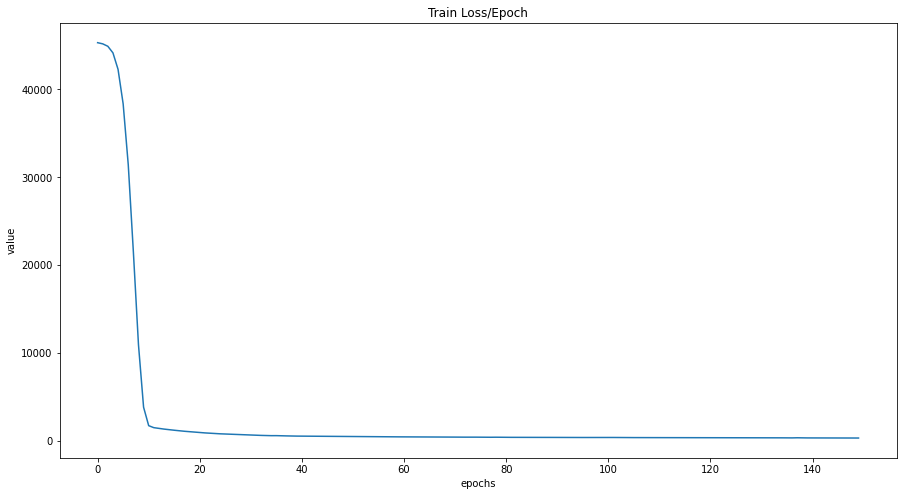

In [26]:
# plotting training loss
train_val_loss_df = pd.DataFrame(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value").set_title('Train Loss/Epoch')

# Testing the neural net

We use mean square error (MSE) as the testing accuracy metric. This will tell us how well the neural network performed in predicting the CPI. 

In [27]:
y_pred = []

# using test data to get predicted CPI values
with torch.no_grad(): #don't want to use backpropogation here
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        X_batch = X_batch.float()
        y_test_pred = model(X_batch).cpu().detach().numpy().reshape(-1)
        y_pred.append(y_test_pred)

y_pred = [a.squeeze().tolist() for a in y_pred]

In [28]:
# calculcating MSE for accuracy metric
mse = mean_squared_error(y_test, y_pred)
print("MSE =", mse)

MSE = 297.10388699733295


We also plot a comparison between the actual and predicted CPI's for a visual on the neural net's performance.

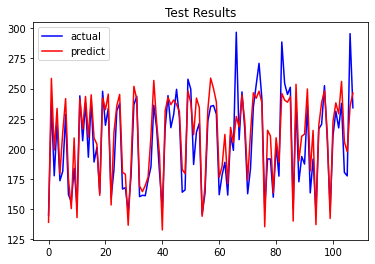

In [29]:
plt.plot(y_test, color = 'blue', label = 'actual') 
plt.plot(y_pred, color = 'red', label = 'predict') 
plt.title('Test Results')
plt.legend()
plt.show()